# DATATHON IBK 2020

In [198]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import gc
import pprint
import joblib
from time import time
from tqdm.notebook import tqdm

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.metrics import roc_auc_score

pd.set_option('display.max_columns', None)
%matplotlib inline
sns.set_theme(style="ticks")

In [2]:
rcc_train = pd.read_csv('data/rcc_train.csv') # Historial crediticio
se_train = pd.read_csv('data/se_train.csv',index_col='key_value') # Información socioeconómica
sunat_train = pd.read_csv('data/sunat_train.csv') # Información fiscal
#censo_train = pd.read_csv('data/censo_train.csv',index_col='key_value') # Información censal
y_train = pd.read_csv('data/y_train.csv',index_col='key_value').target
#productos = pd.read_csv('data/productos.csv',index_col='Productos')

rcc_test = pd.read_csv('data/rcc_test.csv')
se_test = pd.read_csv('data/se_test.csv',index_col='key_value')
sunat_test = pd.read_csv('data/sunat_test.csv')
#censo_test = pd.read_csv('data/censo_test.csv',index_col='key_value')

In [3]:
rcc_train.drop_duplicates(inplace=True)
rcc_test.drop_duplicates(inplace=True)
sunat_train.drop_duplicates(inplace=True)
sunat_test.drop_duplicates(inplace=True)
#censo_train.drop_duplicates(inplace=True)
#censo_test.drop_duplicates(inplace=True)

In [4]:
def get_correlated(data, cut=0.85):
    correlated_features = set()
    correlation_matrix = data.corr()

    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > cut:
                colname = correlation_matrix.columns[i]
                correlated_features.add(colname)

    return correlated_features

In [346]:
def corr_plot(matrix):
    f, ax = plt.subplots(figsize=(10, 7))
    mask = np.triu(np.ones_like(matrix, dtype=bool))-np.identity(matrix.shape[0])
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    sns.heatmap(matrix, mask=mask, cmap=cmap, center=0, square=True,
                linewidths=.5, cbar_kws={"shrink": .5},ax=ax)
    plt.show()

In [154]:
def plot_porc(df,var):
    porcs = pd.DataFrame([[i, df[df[var]==i]['target'].sum()/df[df[var]==i].shape[0],
                           df[df[var]==i]['target'].sum()/df['target'].sum(),
                           df[df[var]==i].shape[0]/df[var].shape[0]]
                           for i in df[var].unique()])
    porcs.columns = [var,'porc_1','peso_1','peso_cat']#f'count_{var}'
    porcs.sort_values(var,inplace=True)
    porcs.set_index(var,inplace=True)
    f, ax = plt.subplots(figsize=(10,5))
    sns.lineplot(data=porcs,markers=True, dashes=False,legend=True,ax=ax,palette='mako')
    ax.grid(axis='y') 

## EDA

                                         Plots for condicion                                          


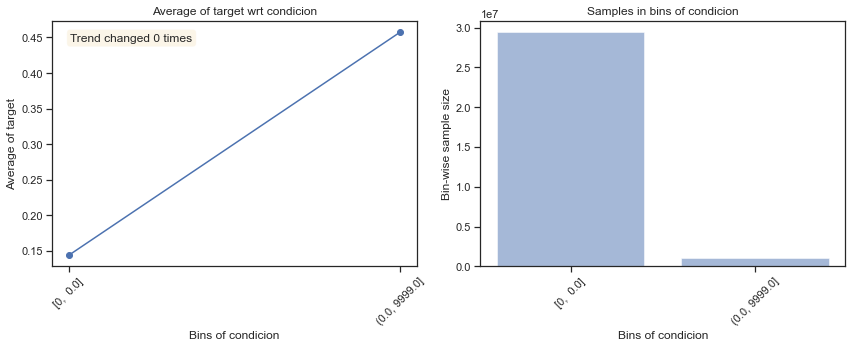

--------------------------------------------------------------------------------------------------------------


                                           Plots for saldo                                            


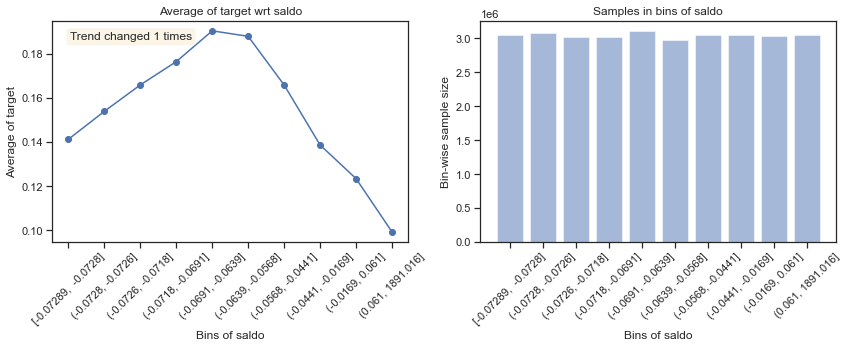

--------------------------------------------------------------------------------------------------------------


                                   Plots for cod_instit_financiera                                    


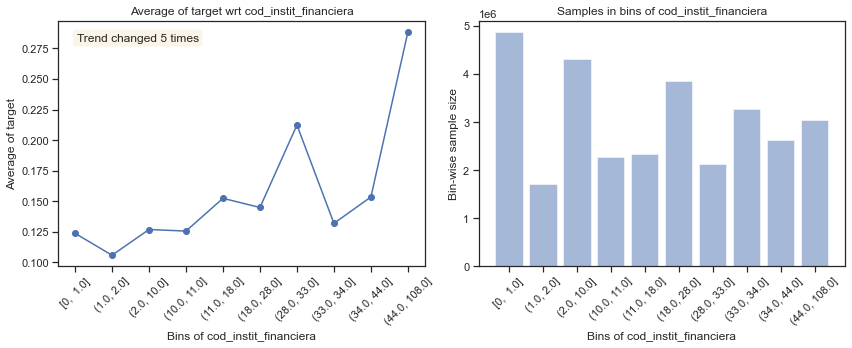

--------------------------------------------------------------------------------------------------------------




In [5]:
from featexp import get_univariate_plots
feat = rcc_train.merge(y_train, on='key_value', how='left')
get_univariate_plots(data=feat, target_col='target', features_list=['condicion','saldo','cod_instit_financiera'])

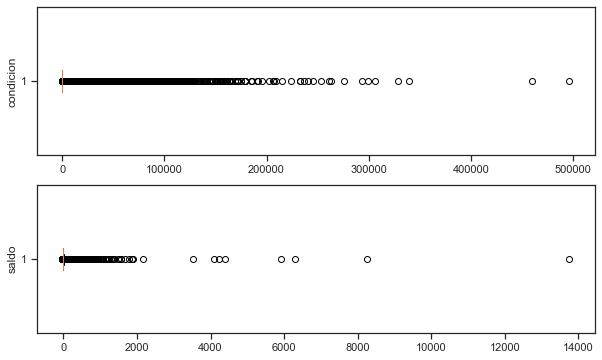

In [6]:
f, ax = plt.subplots(2, 1, figsize=(10, 6))
bp_cat = rcc_train.groupby(['key_value'])[['condicion', 'saldo']].sum()
ax[0].boxplot(bp_cat.condicion, vert=False)
ax[0].set_ylabel('condicion')
ax[1].boxplot(bp_cat.saldo, vert=False)
ax[1].set_ylabel('saldo')
plt.show()

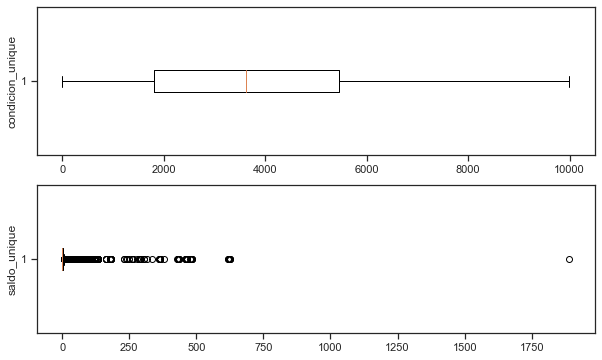

In [7]:
f, ax = plt.subplots(2, 1, figsize=(10, 6))
ax[0].boxplot(rcc_train.condicion.unique(), vert=False)
ax[0].set_ylabel('condicion_unique')
ax[1].boxplot(rcc_train.saldo.unique(), vert=False)
ax[1].set_ylabel('saldo_unique')
plt.show()

In [158]:
a = pd.DataFrame(np.sort(rcc_train.saldo.unique())).diff().dropna()
a.columns = ['saldo']
coef = a.saldo.min()
a.describe()

,saldo
count,190284.000000
mean,0.009938
std,2.921089
min,0.000011
25%,0.000011
50%,0.000011
75%,0.000034
max,1263.978341


In [11]:
b = rcc_train[['saldo']]/coef+10000

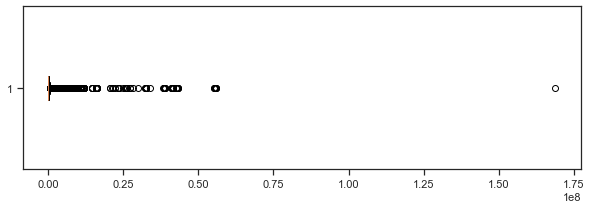

In [12]:
f, ax = plt.subplots(figsize=(10, 3))
ax.boxplot(b.saldo.unique(), vert=False);

In [164]:
rcc_train.drop(columns={'key_value','saldo','condicion'}).nunique()

codmes                       12
tipo_credito                  8
cod_instit_financiera       109
PRODUCTO                     42
RIESGO_DIRECTO                5
COD_CLASIFICACION_DEUDOR      6
dtype: int64

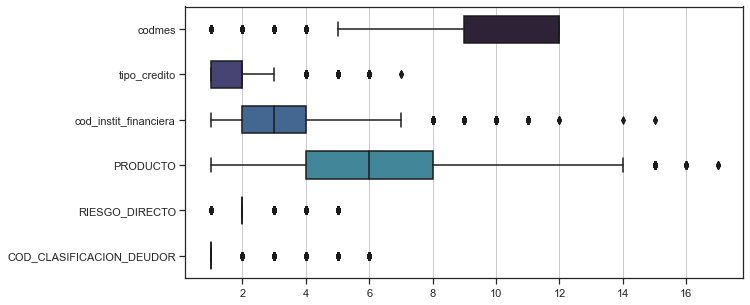

In [187]:
nunique_data = rcc_train.drop(columns={'condicion','saldo'}).groupby(['key_value']).nunique()
sns.boxplot(data=nunique_data,width=.6,palette='mako',orient='hor')
plt.grid(axis='x');

In [ ]:
#plt.scatter(x=censo_train.lon_x, y=censo_train.lat_y,c=censo_train.zon_com)

In [15]:
del feat, bp_cat, nunique_data
gc.collect()

20031

## Start with Credit History

In [6]:
rcc_test.PRODUCTO.replace(np.nan,255,inplace=True)

In [57]:
rcc_test[pd.isnull(rcc_test.cod_instit_financiera)].key_value.nunique()

43

In [58]:
for i in ['tipo_credito','PRODUCTO','RIESGO_DIRECTO','COD_CLASIFICACION_DEUDOR']:
    print(f'{i}: {rcc_test[pd.isnull(rcc_test.cod_instit_financiera)][i].unique()}')

tipo_credito: [99 10  9]
PRODUCTO: [12. 23. 36.  9.]
RIESGO_DIRECTO: [-1  5]
COD_CLASIFICACION_DEUDOR: [5 4]


In [59]:
idx = rcc_test[pd.isnull(rcc_test.cod_instit_financiera)&((rcc_test.PRODUCTO==12)|(rcc_test.PRODUCTO==23)|(rcc_test.PRODUCTO==36)|(rcc_test.PRODUCTO==9))].key_value.unique()

In [62]:
rcc_test.set_index('key_value').loc[idx].groupby(['key_value','PRODUCTO'])[['cod_instit_financiera']].nunique().sort_values('cod_instit_financiera',ascending=False)

cod_instit_financiera
key_value PRODUCTO                       
250942    6.0                           5
195783    12.0                          4
342033    12.0                          4
104254    6.0                           4
323788    0.0                           4
...                                   ...
173912    1.0                           1
          2.0                           1
146162    0.0                           1
301466    23.0                          0
          36.0                          0

[258 rows x 1 columns]

In [61]:
rcc_test.set_index('key_value').loc[idx].groupby(['key_value','PRODUCTO'])[['cod_instit_financiera']].nunique().value_counts()

cod_instit_financiera
1                        180
2                         54
3                         15
4                          6
0                          2
5                          1
dtype: int64

In [12]:
rcc_test[(rcc_test.key_value==146162)&(rcc_test.PRODUCTO==12)&(rcc_test.tipo_credito==10)].sort_values('codmes')

,codmes,key_value,condicion,tipo_credito,cod_instit_financiera,saldo,PRODUCTO,RIESGO_DIRECTO,COD_CLASIFICACION_DEUDOR
28580590,201803,146162,9999,10,26.0,-0.020903,12.0,-1,5
29436130,201804,146162,9999,10,26.0,-0.020903,12.0,-1,5
17318468,201805,146162,9999,10,26.0,-0.020903,12.0,-1,5
21158084,201806,146162,9999,10,26.0,-0.020903,12.0,-1,5
26616908,201807,146162,9999,10,26.0,-0.020903,12.0,-1,5
1163590,201808,146162,9999,10,NaN,-0.020903,12.0,-1,5
11269531,201809,146162,9999,10,NaN,-0.020903,12.0,-1,5
29436753,201810,146162,9999,10,NaN,-0.020903,12.0,-1,5
22336338,201811,146162,0,10,NaN,-0.020903,12.0,-1,5
29430067,201812,146162,0,10,NaN,-0.020903,12.0,-1,5


In [27]:
rcc_test[(rcc_test.key_value==250942)&(rcc_test.PRODUCTO==12)].sort_values('codmes')

,codmes,key_value,condicion,tipo_credito,cod_instit_financiera,saldo,PRODUCTO,RIESGO_DIRECTO,COD_CLASIFICACION_DEUDOR
24930391,201803,250942,208,12,30.0,0.318632,12.0,-1,5
33056887,201804,250942,238,12,30.0,0.318632,12.0,-1,5
24270150,201805,250942,269,12,30.0,0.318632,12.0,-1,5
5480422,201806,250942,299,12,30.0,0.318632,12.0,-1,5
21682630,201807,250942,330,12,30.0,0.318632,12.0,-1,5
3598181,201808,250942,361,99,NaN,0.315273,12.0,-1,5
4533214,201809,250942,390,99,NaN,0.308555,12.0,-1,5


In [36]:
rcc_test[(rcc_test.tipo_credito==99)].sort_values('codmes').cod_instit_financiera.unique()

array([ 17.,   3.,   2.,  41.,  18.,  13.,  30.,  29.,  82.,  57.,  25.,
        10.,   1.,  56.,  36.,  51.,  95.,  21.,   4.,  80.,  75.,  40.,
         0., 101.,  68.,  34.,  69.,  20.,  84.,  nan,   8.,  33.,  38.])

In [45]:
rcc_train[rcc_train.tipo_credito==99].cod_instit_financiera.unique()

array([ 17,  18,   3,   2,  29,  30,  57,  13,  56,  82,  10,  51,   1,
        36,  41,  25, 102, 101,  34,  80,   0,  75,  95,   4,  81,  68,
        40,  69,   8,  74,  21,  28,  84,  62,  15,  39, 108])

In [ ]:
rcc_test.cod_instit_financiera = rcc_test.cod_instit_financiera.astype('int64')
rcc_test.PRODUCTO = rcc_test.PRODUCTO.astype('int64')

In [159]:
varsN = ['condicion','saldo']
varsC = ['tipo_credito','cod_instit_financiera','PRODUCTO','RIESGO_DIRECTO',
         'COD_CLASIFICACION_DEUDOR']

In [160]:
def diferent_vals_cat(train,test,varC):
    diferentes = {}
    uniques_train =  sorted(train[varC].unique())
    uniques_test =  sorted(test[varC].unique())
    diferentes['train'] = list(j for j in uniques_train if j not in uniques_test)
    diferentes['test'] = list(j for j in uniques_test if j not in uniques_train)
    print("*"*10, varC, "*"*10)
    print(f"Not in test: {diferentes['train']}\nNot in train: {diferentes['test']}")

In [161]:
diferent_vals_cat(rcc_train,rcc_test,'cod_instit_financiera')

********** cod_instit_financiera **********
Not in test: [5, 31, 58, 66, 67, 72, 74, 81, 83, 87, 98, 102, 103]
Not in train: [nan]


In [162]:
rcc_train['saldo'] = rcc_train.saldo/coef+10000
rcc_test['saldo'] = rcc_test.saldo/coef+10000

In [163]:
rcc_train['dummy_29_33'] = np.where((rcc_train.cod_instit_financiera>=29)&(rcc_train.cod_instit_financiera<=33),1,0)
rcc_test['dummy_29_33'] = np.where((rcc_test.cod_instit_financiera>=29)&(rcc_test.cod_instit_financiera<=33),1,0)

rcc_train['dummy_45_108'] = np.where(rcc_train.cod_instit_financiera>=45,1,0)
rcc_test['dummy_45_108'] = np.where(rcc_test.cod_instit_financiera>=45,1,0)

In [164]:
bins = [-1, 0, 10, 30, 180, 720, float("inf")]
rcc_train["condicion_cat"] = pd.cut(rcc_train.condicion, bins)
rcc_train["condicion_cat"] = rcc_train["condicion_cat"].cat.codes
rcc_test["condicion_cat"] = pd.cut(rcc_test.condicion, bins)
rcc_test["condicion_cat"] = rcc_test["condicion_cat"].cat.codes

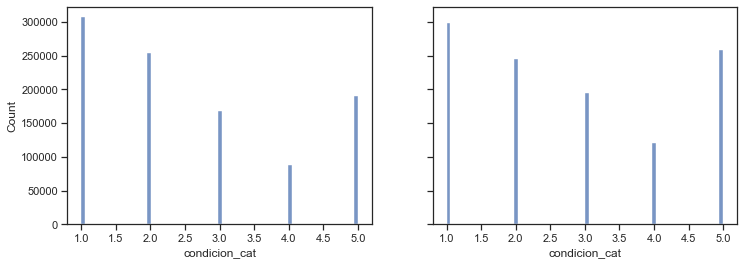

In [12]:
f, ax = plt.subplots(1, 2, figsize=(12, 4),sharey=True)
sns.histplot(data=rcc_train[rcc_train.condicion_cat!=0],x='condicion_cat',ax=ax[0])
sns.histplot(data=rcc_test[rcc_test.condicion_cat!=0],x='condicion_cat',ax=ax[1])
plt.show()

In [165]:
moda = lambda x: pd.Series.mode(x)[0]
moda.__name__ = 'mode'
diff_mean = lambda x: x.diff().mean()
diff_mean.__name__ = 'diff_mean'
diff_std = lambda x: x.diff().std()
diff_std.__name__ = 'diff_std'
diff_sum = lambda x: x.diff().sum()
diff_sum.__name__ = 'diff_sum'

In [166]:
def agg_df(df):
    varsN = ['key_value','condicion','saldo'] #Numeric
    varsC = rcc_train.drop(columns={'codmes','condicion','saldo','dummy_29_33','dummy_45_108'}).columns #Categorical
    varsD = ['key_value','dummy_29_33','dummy_45_108']#Dummies
    
    aggfuncs1 = ['mean','std','min','max']
    aggfuncs2 = [moda,'nunique'] #mean
    aggfuncs3 = [moda,'mean','max','sum']
    aggfuncs4 = [diff_mean,diff_std,diff_sum]

    dfN = df[varsN].groupby(['key_value']).agg(aggfuncs1)
    dfC = df[varsC].groupby(['key_value']).agg(aggfuncs2)
    dfD = df[varsD].groupby(['key_value']).agg(aggfuncs3)
    dfX = df.groupby(['key_value','codmes'])[['saldo']].sum().reset_index()
    dfX = dfX.drop(columns='codmes').groupby(['key_value']).agg(aggfuncs4)
    
    df_agg = pd.concat([dfN,dfC,dfD,dfX],axis=1)
    df_agg.columns = [a+'_'+b for a,b in df_agg.columns]
    return df_agg

In [167]:
%%time
train = agg_df(rcc_train)
test = agg_df(rcc_test)

CPU times: user 21min 53s, sys: 34.8 s, total: 22min 28s
Wall time: 22min 26s


In [168]:
print(f'Train:{train.shape}\nTest:{test.shape}')

Train:(358487, 31)
Test:(396666, 31)


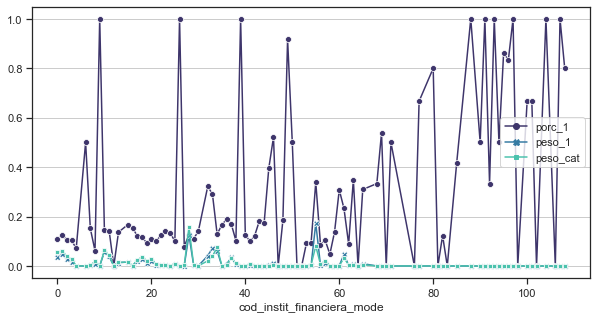

In [176]:
plot_porc(train.join(y_train),'cod_instit_financiera_mode') 

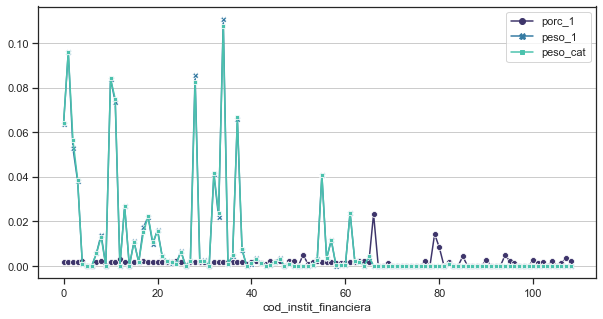

In [177]:
plot_porc(rcc_train.join(y_train),'cod_instit_financiera') 

In [ ]:
def product_diff(df):
    d = df.groupby(['key_value','codmes','PRODUCTO'])[['saldo']].sum().reset_index()
    base = pd.crosstab(d['key_value'],d['PRODUCTO'],values=d['saldo'],aggfunc=diff_mean)
    base.columns = [f"Prod_{v}_diff_mean" for v in base.columns]
    return base

In [ ]:
#base.count()[base.count()>1000]

In [ ]:
%%time
base_train = product_diff(rcc_train)
base_test = product_diff(rcc_test)

In [ ]:
train = train.join(base_train)
test = test.join(base_test)

del base_train, base_test
gc.collect()

In [ ]:
print(f'Train:{train.shape}\nTest:{test.shape}')

In [101]:
df = train[train.condicion_mean>0]
np.round(df.shape[0]/rcc_train.shape[0]*100,decimals=2)

0.35

In [102]:
df = rcc_train[rcc_train.condicion>0]
np.round(df.shape[0]/rcc_train.shape[0]*100,decimals=2)

3.31

In [ ]:
def makeCt(df, c, var, aggfunc=sum):
    try:
        ct = pd.crosstab(df.key_value, df[c].fillna("N/A"), values=df[var], aggfunc=aggfunc)
    except:
        ct = pd.crosstab(df.key_value, df[c], values=df[var], aggfunc=aggfunc)
    ct.columns = [f"{c}_{v}_{aggfunc.__name__}_{var}" for v in ct.columns]
    return ct

In [ ]:
rcc_ct = []
rcc_test_ct = []
aggfuncs = [len, min, max, sum, np.mean, np.std]
aggfuncs2 = [min, max, sum, np.mean]

for c in tqdm(rcc_train.drop(columns={'codmes','key_value','saldo','condicion','dummy_29_33','dummy_45_108'}).columns):
    print('Loading', c)
    rcc_ct.extend([makeCt(rcc_train, c, 'saldo', aggfunc) for aggfunc in aggfuncs])
    rcc_test_ct.extend([makeCt(rcc_test, c, 'saldo', aggfunc) for aggfunc in aggfuncs])
    #if c != 'condicion_cat':
        #rcc_ct.extend([makeCt(rcc_train, c, 'condicion', aggfunc) for aggfunc in aggfuncs2])
        #rcc_test_ct.extend([makeCt(rcc_test, c, 'condicion', aggfunc) for aggfunc in aggfuncs2])    
    
print('Concatenating')
rcc_ct = pd.concat(rcc_ct, axis=1)
rcc_test_ct = pd.concat(rcc_test_ct, axis=1)

In [ ]:
train = train.join(rcc_ct)
test = test.join(rcc_test_ct)

del rcc_ct, rcc_test_ct
gc.collect()

In [ ]:
print(f'Train:{train.shape}\nTest:{test.shape}')

## Add SocioEconomic data

In [ ]:
se_train[pd.isnull(se_train.cod_ubi)].lgr_vot.value_counts()

In [ ]:
se_train[se_train.lgr_vot==22].cod_ubi.value_counts()

In [351]:
varsN = ['edad','ctd_hijos','ctd_veh']
varsC = ['sexo','est_cvl','sit_lab','cod_ocu','flg_sin_email','cod_ubi','lgr_vot','prv','dto','rgn','tip_lvledu']

In [ ]:
def impCod_ubi(df):
    cod_ubi_imp = df[pd.isnull(df.cod_ubi)]
    for x in cod_ubi_imp.lgr_vot.unique():
        busc = df[df.lgr_vot==x].groupby(['prv','dto']).agg('mean').reset_index()
        idx = cod_ubi_imp[cod_ubi_imp.lgr_vot==x].index
        for y in idx:
            prov = df.loc[y].prv
            dep = df.loc[y].dto
            val = busc[(busc.prv==prov)&(busc.dto==dep)].cod_ubi.values[0]        
            if pd.isnull(val):
                val = busc[(busc.dto==dep)].cod_ubi.mean()
                if pd.isnull(val):
                    val = busc[(busc.prv==prov)].cod_ubi.mean()
                    if pd.isnull(val):
                        val = busc.cod_ubi.mean()
            df.loc[y,'cod_ubi'] = val

In [ ]:
impCod_ubi(se_train)
impCod_ubi(se_test)

In [ ]:
def impEdad(df):
    imp = IterativeImputer(max_iter=10, random_state=0)
    #imp.fit(df.drop(columns={'cod_ubi','lgr_vot','prv','dto','rgn'}))
    imp.fit(df)
    edad_null = df[pd.isnull(df.edad)]
    df.loc[edad_null.index,'edad'] = imp.transform(edad_null)[:,0]

In [ ]:
impEdad(se_train)
impEdad(se_test)

In [31]:
se_train.head()

,edad,sexo,est_cvl,sit_lab,cod_ocu,ctd_hijos,flg_sin_email,ctd_veh,cod_ubi,lgr_vot,prv,dto,rgn,tip_lvledu
key_value,,,,,,,,,,,,,,
0,-0.983651,1,4,2,22,0.0,1,0.0,-0.070167,17,47,687,4,0
1,0.000953,1,4,1,22,0.0,1,1.0,-0.738566,10,186,849,6,0
2,0.531124,0,4,1,22,0.0,1,0.0,-0.297248,15,84,1405,1,7
3,-1.135129,0,4,1,22,0.0,1,0.0,-1.203435,4,9,977,6,7
4,-1.438084,0,4,1,22,0.0,1,0.0,0.043424,18,111,391,3,0


In [ ]:
train = train.join(se_train)
test = test.join(se_test)

del se_train, se_test
gc.collect()

In [ ]:
print(f'Train:{train.shape}\nTest:{test.shape}')

## Add Tributary data

In [304]:
sunat_train = pd.read_csv('data/sunat_train.csv')
sunat_test = pd.read_csv('data/sunat_test.csv')
sunat_train.drop_duplicates(inplace=True)
sunat_test.drop_duplicates(inplace=True)

In [305]:
sunat_train['tiempo'] = sunat_train.fecbaja - sunat_train.fecalta
sunat_test['tiempo'] = sunat_test.fecbaja - sunat_test.fecalta

sunat_train['activo'] = np.where(pd.isnull(sunat_train.fecbaja),1,0)
sunat_test['activo'] = np.where(pd.isnull(sunat_test.fecbaja),1,0)

sunat_train['fecbaja_act'] = sunat_train['fecbaja'].replace(np.nan,sunat_train['fecbaja'].max())
sunat_test['fecbaja_act'] = sunat_test['fecbaja'].replace(np.nan,sunat_test['fecbaja'].max())

sunat_train['tiempo_tot'] = sunat_train.fecbaja_act - sunat_train.fecalta
sunat_test['tiempo_tot'] = sunat_test.fecbaja_act - sunat_test.fecalta

In [331]:
varsN = ['fecalta','fecbaja','tiempo','fecbaja_act','tiempo_tot','key_value']
varsC = ['tipcontribuyente','tippersona','ciiu','ubigeo','condiciondomicilio',
         'estadocontribuyente','codvia','codzona','contabilidad','facturacion',
        'domiciliado','comercioexterior','cargorele','codentidadtributo','estadotributo','key_value']#,'activo'

In [307]:
diferent_vals_cat(sunat_train,sunat_test,'ciiu')

********** ciiu **********
Not in test: [25, 92, 97, 132, 203]
Not in train: [1, 7, 99, 126]


In [308]:
sunat_train.drop(columns={'key_value'}).nunique()

tipcontribuyente         50
tippersona                3
ciiu                    285
ubigeo                 1655
condiciondomicilio       15
estadocontribuyente      13
fecalta                  27
fecbaja                  28
codvia                   29
codzona                  36
contabilidad             12
facturacion              21
domiciliado               3
comercioexterior         14
cargorele               656
codentidadtributo         9
estadotributo             3
tiempo                  384
activo                    2
fecbaja_act              28
tiempo_tot              392
dtype: int64

In [309]:
sunat_test.drop(columns={'key_value'}).nunique()

tipcontribuyente         48
tippersona                4
ciiu                    284
ubigeo                 1669
condiciondomicilio       15
estadocontribuyente      12
fecalta                  28
fecbaja                  29
codvia                   29
codzona                  36
contabilidad             12
facturacion              22
domiciliado               3
comercioexterior         14
cargorele               709
codentidadtributo         8
estadotributo             3
tiempo                  389
activo                    2
fecbaja_act              29
tiempo_tot              391
dtype: int64

In [339]:
def agg_df_2(df):
    global varsN
    global varsC
    
    aggfuncs1 = {'fecalta':['min'],'fecbaja_act':['max'],'tiempo_tot':['sum']}
    aggfuncs2 = [moda,'nunique']
    aggfuncs3 = {'activo':['max']}

    dfN = df[varsN].drop_duplicates().groupby(['key_value']).agg(aggfuncs1)
    dfC = df[varsC].groupby(['key_value']).agg(aggfuncs2)#.remove('activo')
    dfA = df.groupby(['key_value','ciiu']).agg(aggfuncs3)
    dfA = dfA.groupby(['key_value']).sum()
    
    df_agg = pd.concat([dfN,dfC,dfA],axis=1)
    df_agg.columns = [a+'_'+b for a,b in df_agg.columns]
    df_agg['tiempo_est'] = df_agg.fecbaja_act_max - df_agg.fecalta_min
    df_agg.rename(columns={'activo_max':'activoXciiu_max','tiempo_tot_sum':'tiempo_tot_efec'},inplace=True)
    return df_agg

In [340]:
%%time
sunat_agg = agg_df_2(sunat_train)
#sunat_test_agg = agg_df_2(sunat_test)

CPU times: user 7min 27s, sys: 2.71 s, total: 7min 30s
Wall time: 7min 28s


In [341]:
sunat_agg

,fecalta_min,fecbaja_act_max,tiempo_tot_efec,tipcontribuyente_mode,tipcontribuyente_nunique,tippersona_mode,tippersona_nunique,ciiu_mode,ciiu_nunique,ubigeo_mode,ubigeo_nunique,condiciondomicilio_mode,condiciondomicilio_nunique,estadocontribuyente_mode,estadocontribuyente_nunique,codvia_mode,codvia_nunique,codzona_mode,codzona_nunique,contabilidad_mode,contabilidad_nunique,facturacion_mode,facturacion_nunique,domiciliado_mode,domiciliado_nunique,comercioexterior_mode,comercioexterior_nunique,cargorele_mode,cargorele_nunique,codentidadtributo_mode,codentidadtributo_nunique,estadotributo_mode,estadotributo_nunique,activoXciiu_max,tiempo_est
key_value,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.971584,2.168508,1.196924,9,1,0,1,178,1,404,1,0,1,0,1,20,1,11,1,6,1,11,1,0,1,2,1,635,1,8,1,2,1,1,1.196924
1,0.566027,2.168508,1.602481,0,1,0,1,285,1,1670,1,0,1,0,1,3,1,3,1,2,1,2,1,0,1,2,1,635,1,8,1,2,1,1,1.602481
2,0.701213,2.168508,1.467296,0,1,0,1,285,1,228,1,0,1,0,1,11,1,3,1,6,1,11,1,0,1,1,1,635,1,8,1,2,1,1,1.467296
3,1.512328,2.168508,0.656180,9,1,0,1,177,1,1761,1,0,1,0,1,3,1,3,1,2,1,2,1,0,1,2,1,635,1,6,1,1,1,1,0.656180
5,-1.191390,2.168508,1.319308,9,1,0,1,283,1,466,2,0,1,0,2,3,1,0,2,1,2,1,2,0,1,2,1,635,1,8,1,2,1,1,3.359898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358481,1.917886,2.168508,0.250622,9,1,0,1,178,1,442,1,0,1,2,1,0,1,3,1,6,1,17,1,0,1,1,1,635,1,8,1,2,1,1,0.250622
358482,0.430841,2.168508,1.737667,0,1,0,1,253,1,557,1,0,1,0,1,20,1,0,1,6,1,11,1,0,1,1,1,635,1,8,1,2,1,1,1.737667
358484,1.782700,2.168508,0.385808,0,1,0,1,285,1,13,1,0,1,0,1,3,1,3,1,10,1,17,1,0,1,1,1,635,1,6,1,1,1,1,0.385808


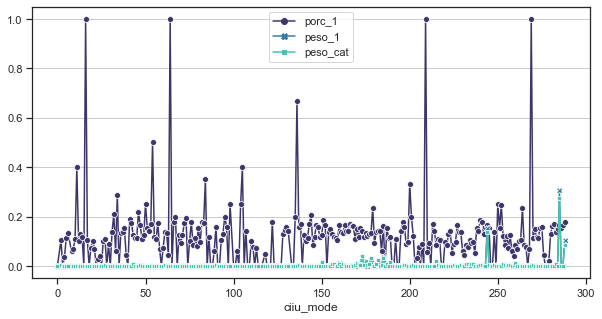

In [348]:
plot_porc(sunat_agg.join(y_train),'ciiu_mode') 

In [ ]:
train = train.join(sunat_agg)
test = test.join(sunat_test_agg)

del sunat_agg, sunat_test_agg
gc.collect()

In [ ]:
print(f'Train:{train.shape}\nTest:{test.shape}')

In [234]:
sunat_train[['fecalta','fecbaja','tiempo','fecbaja_act','tiempo_tot']].isna().sum()

fecalta         20452
fecbaja        245677
tiempo         245678
fecbaja_act         0
tiempo_tot      20452
dtype: int64

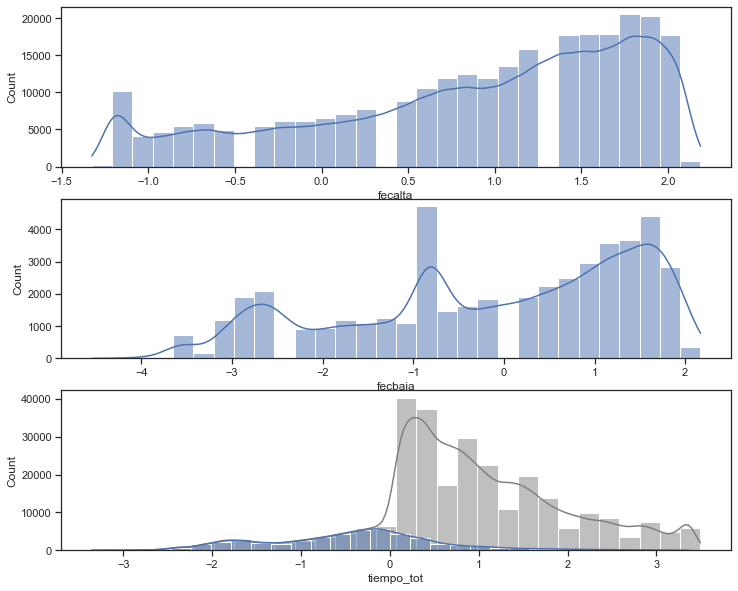

In [236]:
f, ax = plt.subplots(3,1,figsize=(12,10))
sns.histplot(data=sunat_train[['fecalta']].dropna(),x='fecalta',bins=30,kde=True,ax=ax[0])
#sns.histplot(data=sunat_train[['fecbaja_act']].dropna(),x='fecbaja_act',bins=30,kde=True,color='gray',ax=ax[1])
sns.histplot(data=sunat_train[['fecbaja']].dropna(),x='fecbaja',bins=30,kde=True,ax=ax[1])
sns.histplot(data=sunat_train[['tiempo_tot']].dropna(),x='tiempo_tot',bins=30,kde=True,color='gray',ax=ax[2])
sns.histplot(data=sunat_train[['tiempo']].dropna(),x='tiempo',bins=30,kde=True,ax=ax[2])
plt.show()

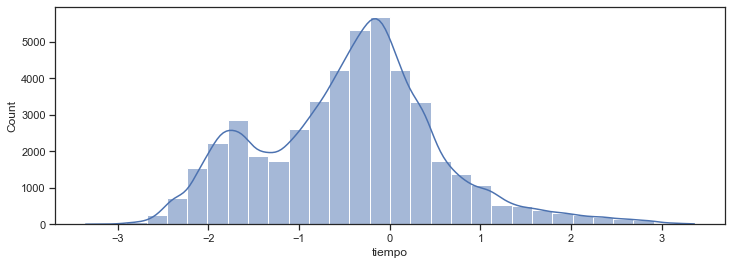

In [237]:
f, ax = plt.subplots(figsize=(12,4))
sns.histplot(data=sunat_train[['tiempo']].dropna(),x='tiempo',bins=30,kde=True,ax=ax);

In [238]:
print(f'Before: {sunat_train.tiempo.mean()}, {sunat_train.tiempo.std()}\nAfter: {sunat_train.tiempo_tot.mean()}, {sunat_train.tiempo_tot.std()}')

Before: -0.43148515984367763, 0.979216169291968
After: 0.907142336277981, 1.0866408310953237


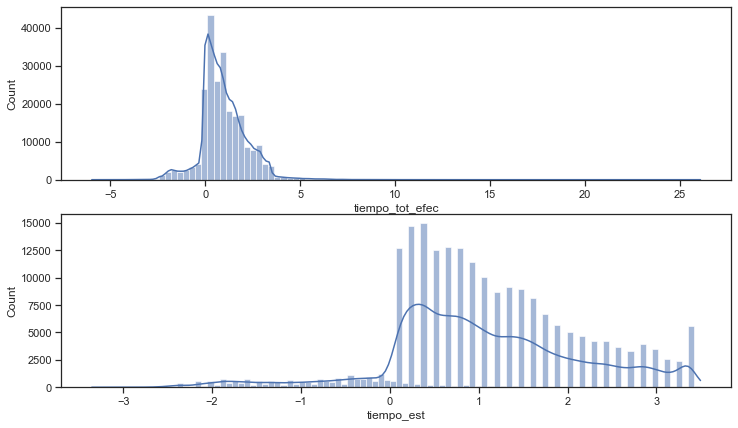

In [343]:
f, ax = plt.subplots(2,1,figsize=(12,7))
sns.histplot(data=sunat_agg[['tiempo_tot_efec']].dropna(),x='tiempo_tot_efec',bins=100,kde=True,ax=ax[0]);
sns.histplot(data=sunat_agg[['tiempo_est']].dropna(),x='tiempo_est',bins=100,kde=True,ax=ax[1]);

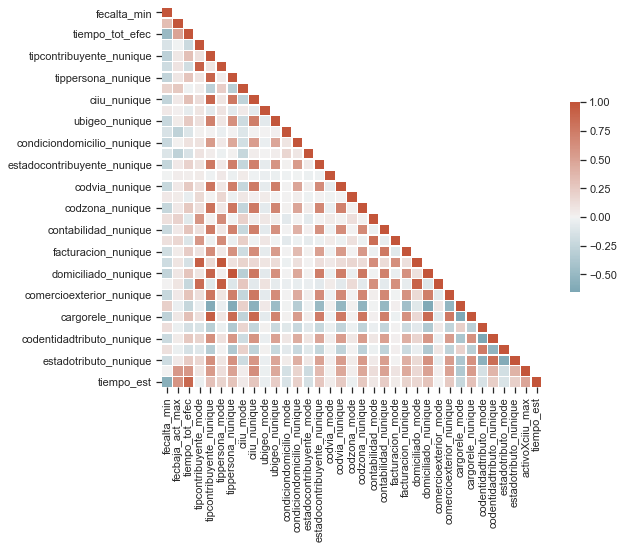

In [347]:
corr_plot(sunat_agg.corr())

In [69]:
sunat_train[sunat_train.key_value==230796].groupby(['key_value','ciiu']).nunique()

tipcontribuyente  tippersona  ubigeo  condiciondomicilio  \
key_value ciiu                                                             
230796    12                   1           1       1                   1   
          70                   2           1       1                   1   
          77                   1           1       1                   1   
          148                  1           1       1                   1   
          150                  2           1       1                   1   
          151                  1           1       1                   1   
          157                  1           1       1                   1   
          162                  1           1       2                   1   
          164                  1           1       1                   1   
          167                  1           1       1                   1   
          169                  1           1       1                   1   
          170                  1           1       1                   1   
          189                  1           1       1                   1   
          191                  1           1       1                   1   
          207                  1           1       1                   1   
          216                  1           1       1                   1   
          225                  2           1       2                   1   
          235                  1           1       3                   1   
          236                  1           1       2                   1   
          244                  1           1       3                   1   
          257                  1           1       1                   1   
          270                  1           1       1                   1   
          274                  1           1       1                   1   
          285                  1           1       1                   1   
          288                  1           1       1                   1   

                estadocontribuyente  fecalta  fecbaja  codvia  codzona  \
key_value ciiu                                                           
230796    12                      1        1        1       1        1   
          70                      2        2        1       1        2   
          77                      1        1        0       1        1   
          148                     1        1        0       1        1   
          150                     1        2        0       1        1   
          151                     1        1        0       1        1   
          157                     1        1        1       1        1   
          162                     2        1        1       2        1   
          164                     1        1        0       1        1   
          167                     1        1        0       1        1   
          169                     1        1        0       1        1   
          170                     1        1        0       1        1   
          189                     1        1        1       1        1   
          191                     1        1        0       1        1   
          207                     1        1        0       1        1   
          216                     1        1        0       1        1   
          225                     1        1        0       2        2   
          235                     2        3        1       2        2   
          236                     2        2        0       1        2   
          244                     3        3        2       2        2   
          257                     1        1        1       1        1   
          270                     1        1        0       1        1   
          274                     1        1        0       1        1   
          285                     1        1        1       1        1   
          288                     1    

In [67]:
y_train[230796]

0

In [46]:
filasxcliente = sunat_train.groupby('key_value')[['tipcontribuyente']].count().sort_values('tipcontribuyente',ascending=False)
filasxcliente.columns = ['filas']
filasxcliente.shape

(233866, 1)

In [49]:
idx = filasxcliente[filasxcliente.filas>1].index
filasxcliente[filasxcliente.filas>1].shape

(29784, 1)

In [58]:
unicosxcliente = sunat_train.groupby('key_value').nunique().sort_values('tipcontribuyente',ascending=False)
unicosxcliente = unicosxcliente.loc[idx]
unicosxcliente.describe().T.iloc[:,1:]

,mean,std,min,25%,50%,75%,max
tipcontribuyente,2.145917,0.626713,1.0,2.0,2.0,2.0,8.0
tippersona,1.908609,0.288519,1.0,2.0,2.0,2.0,3.0
ciiu,2.133965,0.912251,1.0,2.0,2.0,2.0,25.0
ubigeo,1.613047,0.749293,1.0,1.0,1.0,2.0,12.0
condiciondomicilio,1.270716,0.477694,1.0,1.0,1.0,2.0,4.0
estadocontribuyente,1.660791,0.588076,1.0,1.0,2.0,2.0,5.0
fecalta,2.240230,0.987620,0.0,2.0,2.0,2.0,19.0
fecbaja,0.662201,0.812107,0.0,0.0,1.0,1.0,9.0
codvia,1.740095,0.664856,1.0,1.0,2.0,2.0,6.0
codzona,1.779042,0.627544,1.0,1.0,2.0,2.0,6.0


In [62]:
unicosxcliente[unicosxcliente.ciiu==25]

,tipcontribuyente,tippersona,ciiu,ubigeo,condiciondomicilio,estadocontribuyente,fecalta,fecbaja,codvia,codzona,contabilidad,facturacion,domiciliado,comercioexterior,cargorele,codentidadtributo,estadotributo
key_value,,,,,,,,,,,,,,,,,
230796,6,2,25,12,2,4,13,8,4,3,5,5,2,9,7,4,3


In [52]:
ciiu_train = pd.crosstab(sunat_train.key_value, sunat_train.ciiu)
ciiu_test = pd.crosstab(sunat_test.key_value, sunat_test.ciiu)

ciiu_train.columns = [f'ciiu_{c}' for c in ciiu_train.columns]
ciiu_test.columns = [f'ciiu_{c}' for c in ciiu_test.columns]

In [54]:
ciiu_train.sort_values(by='ciiu_count',ascending=False).head()

,ciiu_0,ciiu_2,ciiu_3,ciiu_4,ciiu_5,ciiu_6,ciiu_8,ciiu_9,ciiu_10,ciiu_11,ciiu_12,ciiu_13,ciiu_14,ciiu_15,ciiu_16,ciiu_17,ciiu_18,ciiu_19,ciiu_20,ciiu_21,ciiu_22,ciiu_23,ciiu_24,ciiu_25,ciiu_26,ciiu_27,ciiu_28,ciiu_29,ciiu_30,ciiu_31,ciiu_32,ciiu_33,ciiu_34,ciiu_35,ciiu_36,ciiu_37,ciiu_38,ciiu_39,ciiu_40,ciiu_41,ciiu_42,ciiu_43,ciiu_44,ciiu_45,ciiu_46,ciiu_47,ciiu_48,ciiu_49,ciiu_50,ciiu_51,ciiu_52,ciiu_53,ciiu_54,ciiu_55,ciiu_56,ciiu_57,ciiu_58,ciiu_59,ciiu_60,ciiu_61,ciiu_62,ciiu_63,ciiu_64,ciiu_65,ciiu_66,ciiu_67,ciiu_68,ciiu_69,ciiu_70,ciiu_71,ciiu_72,ciiu_73,ciiu_74,ciiu_75,ciiu_76,ciiu_77,ciiu_78,ciiu_79,ciiu_80,ciiu_81,ciiu_82,ciiu_83,ciiu_84,ciiu_85,ciiu_86,ciiu_87,ciiu_88,ciiu_89,ciiu_90,ciiu_91,ciiu_92,ciiu_93,ciiu_94,ciiu_95,ciiu_96,ciiu_97,ciiu_98,ciiu_100,ciiu_101,ciiu_102,ciiu_103,ciiu_104,ciiu_105,ciiu_106,ciiu_107,ciiu_108,ciiu_109,ciiu_110,ciiu_111,ciiu_112,ciiu_113,ciiu_114,ciiu_115,ciiu_116,ciiu_117,ciiu_118,ciiu_119,ciiu_120,ciiu_121,ciiu_122,ciiu_123,ciiu_124,ciiu_125,ciiu_127,ciiu_128,ciiu_129,ciiu_130,ciiu_131,ciiu_132,ciiu_133,ciiu_134,ciiu_135,ciiu_136,ciiu_137,ciiu_138,ciiu_139,ciiu_140,ciiu_141,ciiu_142,ciiu_143,ciiu_144,ciiu_145,ciiu_146,ciiu_147,ciiu_148,ciiu_149,ciiu_150,ciiu_151,ciiu_152,ciiu_153,ciiu_154,ciiu_155,ciiu_156,ciiu_157,ciiu_158,ciiu_159,ciiu_160,ciiu_161,ciiu_162,ciiu_163,ciiu_164,ciiu_165,ciiu_166,ciiu_167,ciiu_168,ciiu_169,ciiu_170,ciiu_171,ciiu_172,ciiu_173,ciiu_174,ciiu_175,ciiu_176,ciiu_177,ciiu_178,ciiu_179,ciiu_180,ciiu_181,ciiu_182,ciiu_183,ciiu_184,ciiu_185,ciiu_186,ciiu_187,ciiu_188,ciiu_189,ciiu_190,ciiu_191,ciiu_192,ciiu_193,ciiu_194,ciiu_195,ciiu_196,ciiu_197,ciiu_198,ciiu_199,ciiu_200,ciiu_201,ciiu_202,ciiu_203,ciiu_204,ciiu_205,ciiu_206,ciiu_207,ciiu_208,ciiu_209,ciiu_210,ciiu_211,ciiu_212,ciiu_213,ciiu_214,ciiu_215,ciiu_216,ciiu_217,ciiu_218,ciiu_219,ciiu_220,ciiu_221,ciiu_222,ciiu_223,ciiu_224,ciiu_225,ciiu_226,ciiu_227,ciiu_228,ciiu_229,ciiu_230,ciiu_231,ciiu_232,ciiu_233,ciiu_234,ciiu_235,ciiu_236,ciiu_237,ciiu_238,ciiu_239,ciiu_240,ciiu_241,ciiu_242,ciiu_243,ciiu_244,ciiu_245,ciiu_246,ciiu_247,ciiu_248,ciiu_249,ciiu_250,ciiu_251,ciiu_252,ciiu_253,ciiu_254,ciiu_255,ciiu_256,ciiu_257,ciiu_258,ciiu_259,ciiu_260,ciiu_261,ciiu_262,ciiu_263,ciiu_264,ciiu_265,ciiu_266,ciiu_267,ciiu_268,ciiu_269,ciiu_270,ciiu_271,ciiu_272,ciiu_273,ciiu_274,ciiu_275,ciiu_276,ciiu_277,ciiu_278,ciiu_279,ciiu_280,ciiu_281,ciiu_282,ciiu_283,ciiu_284,ciiu_285,ciiu_286,ciiu_287,ciiu_288,ciiu_count
key_value,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
262090,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,80,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,96
121911,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28,0,0,0,63
87603,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [55]:
ciiu_train['ciiu_count'].value_counts()

1     204082
2      18129
3       5394
4       2713
5       1386
6        746
7        481
8        268
9        189
10       140
11        84
12        67
13        42
14        36
15        26
17        13
16        11
20         9
18         8
21         7
22         7
19         6
23         5
25         3
30         2
45         2
63         1
38         1
51         1
47         1
28         1
36         1
33         1
27         1
24         1
96         1
Name: ciiu_count, dtype: int64

In [56]:
ciiu_train.shape

(233866, 286)

In [57]:
train = train.join(ciiu_train)
test = test.join(ciiu_test)

del ciiu_train, ciiu_test, #sunat_train, sunat_test
gc.collect()

0

In [58]:
print(f'Train:{train.shape}\nTest:{test.shape}')

Train:(358487, 1430)
Test:(396666, 1363)


## Add Censo data

In [ ]:
#train = train.join(censo_train)
#test = test.join(censo_test)

#del censo_train, censo_test
#gc.collect()

In [ ]:
#train.shape

In [60]:
train_b = train
test_b = test

In [ ]:
keep_cols = list(set(train.columns).intersection(set(test.columns)))
train = train[keep_cols]
test = test[keep_cols]
len(set(train.columns) - set(test.columns)) , len(set(test.columns) - set(train.columns))

In [62]:
train.columns = [str(c) for c in train.columns]
train = train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_-]+', '', x))

test.columns = [str(c) for c in test.columns]
test = test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_-]+', '', x))

In [132]:
print(f'Train:{train.shape}\nTest:{test.shape}')

Train:(358487, 451)
Test:(396666, 451)


In [124]:
count_non_null = train.count().to_dict()
count_non_null = {k: v for k, v in sorted(count_non_null.items(), key=lambda i: i[1], reverse=False) if v<3500}
count_non_null

{'tipo_credito_6_max_saldo': 74,
 'tipo_credito_6_sum_saldo': 74,
 'tipo_credito_6_mean_saldo': 74,
 'tipo_credito_6_len_saldo': 74,
 'tipo_credito_6_min_saldo': 74,
 'tipo_credito_6_std_saldo': 74,
 'RIESGO_DIRECTO_5_std_saldo': 315,
 'RIESGO_DIRECTO_5_sum_saldo': 340,
 'RIESGO_DIRECTO_5_mean_saldo': 340,
 'RIESGO_DIRECTO_5_min_saldo': 340,
 'RIESGO_DIRECTO_5_len_saldo': 340,
 'RIESGO_DIRECTO_5_max_saldo': 340,
 'tipo_credito_8_std_saldo': 525,
 'tipo_credito_8_len_saldo': 532,
 'tipo_credito_8_min_saldo': 532,
 'tipo_credito_8_mean_saldo': 532,
 'tipo_credito_8_max_saldo': 532,
 'tipo_credito_8_sum_saldo': 532,
 'RIESGO_DIRECTO_3_std_saldo': 1925,
 'RIESGO_DIRECTO_3_len_saldo': 2152,
 'RIESGO_DIRECTO_3_sum_saldo': 2152,
 'RIESGO_DIRECTO_3_max_saldo': 2152,
 'RIESGO_DIRECTO_3_mean_saldo': 2152,
 'RIESGO_DIRECTO_3_min_saldo': 2152}

In [130]:
train.drop(columns=count_non_null,inplace=True)
test.drop(columns=count_non_null,inplace=True)

/opt/anaconda3/envs/data_science/lib/python3.7/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [145]:
train['saldo_diff_mean'].describe()

count    3.183220e+05
mean     2.389977e+03
std      1.659851e+04
min     -1.313992e+06
25%      9.545745e+01
50%      1.403949e+03
75%      3.301634e+03
max      3.500615e+06
Name: saldo_diff_mean, dtype: float64

In [301]:
tiempo_efec = lambda x: x.diff().sum()
tiempo_efec.__name__ = 'efec'

In [302]:
a = [[1,2],[1,5],[1,3],[2,1],[2,2],[3,5],[2,2],[3,5],[3,1]]
a = pd.DataFrame(a,columns = ['A','B'])
a

,A,B
0,1,2
1,1,5
2,1,3
3,2,1
4,2,2
5,3,5
6,2,2
7,3,5
8,3,1


In [303]:
a.groupby('A').agg(tiempo_efec)

,B
A,
1,1
2,1
3,-4
